In [1]:
import plotly.express as px
from WaterClass2.core import *
from WaterClass2.Radiometry import RadiometryDB, Radiometry

%load_ext autoreload
%autoreload 2

# TRIOS

> This notebook presents how to use the TRIOS (by Tristan) to correct the reflectances using the irradiance (Ed) and radiances (Ld and Lu)<br>

## Opening the Database

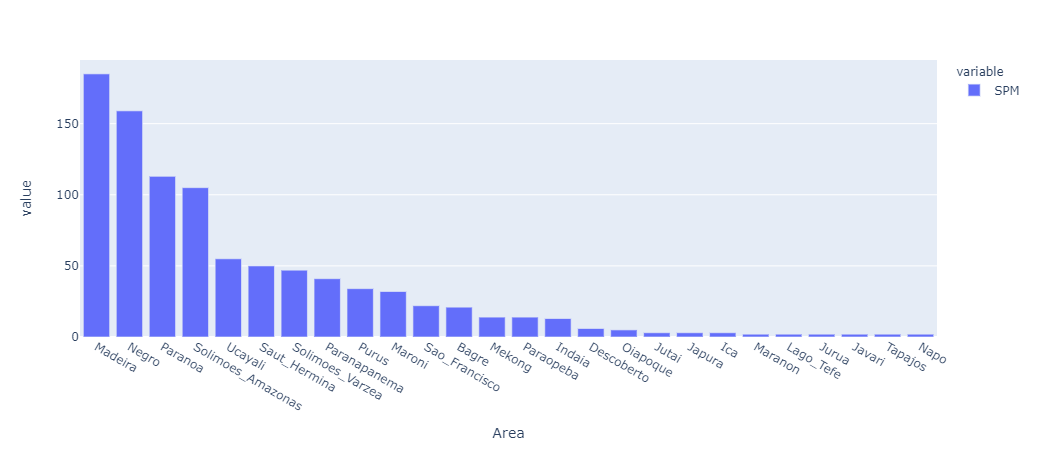

In [13]:
db = RadiometryDB(r'D:\OneDrive - Agência Nacional de Águas\Data\GET-RadiometryDB')

db.summary(plot=True, bars=['SPM'])

## Show Database Update Status

In [15]:
db.status()

---------- DataBase Status ----------
Base Folder: D:\OneDrive - Agência Nacional de Águas\Data\GET-RadiometryDB
Control File: BD-GET-Summary.xlsx (Modified: 2021-07-26 22:42:26)


Summary files:
Ed_summary.csv: Modified on 2021-07-21 17:09:32
Ld_summary.csv: Modified on 2021-07-21 17:09:32
Lu_summary.csv: Modified on 2021-07-21 17:09:33
Rrs_OSOAA_summary.csv: Modified on 2021-03-11 16:40:30
Rrs_summary.csv: Modified on 2021-07-21 17:09:31


Integrity/date table:


,Reflectance,Mean Reflectance,OSOAA Reflectance,Metadata,Graph
2021-07-26,NaN,959.0,959.0,NaN,54.0
2021-07-21,NaN,NaN,NaN,959.0,NaN
2021-06-25,33.0,NaN,NaN,NaN,34.0
2021-06-24,33.0,NaN,NaN,NaN,62.0
2021-06-23,30.0,NaN,NaN,NaN,NaN
2021-06-16,24.0,NaN,NaN,NaN,70.0
2021-06-14,9.0,NaN,NaN,NaN,NaN
2021-06-11,28.0,NaN,NaN,NaN,NaN
2021-06-10,10.0,NaN,NaN,NaN,NaN
2021-06-09,14.0,NaN,NaN,NaN,NaN


## Creating Corrected Reflectances

In [ ]:
db.create_adjusted_reflectance(r'D:\OneDrive - Agência Nacional de Águas\Projects\trios\trios\main.py')#,qry_str='Id>=796')

In [16]:
db.create_summary_radiometries(r_types='Rrs_OSOAA')

Saving radiometry: D:\OneDrive - Agência Nacional de Águas\Data\GET-RadiometryDB\Rrs_OSOAA_summary.csv
Radiometries ['Rrs_OSOAA'] loaded in dictionary .rdmtries


## Plotting Corrected and Raw reflectances

In [20]:
db.load_summary(r_types=['Rrs', 'Rrs_OSOAA'])

Radiometries ['Rrs', 'Rrs_OSOAA'] loaded in dictionary .rdmtries


In [23]:
# concat both Reflectances
db.rdmtries['Rrs']['r_type'] = 'Rrs'
db.rdmtries['Rrs_OSOAA']['r_type'] = 'Rrs_OSOAA'
df = pd.concat([db.rdmtries['Rrs'], db.rdmtries['Rrs_OSOAA']], axis=0)

### All points

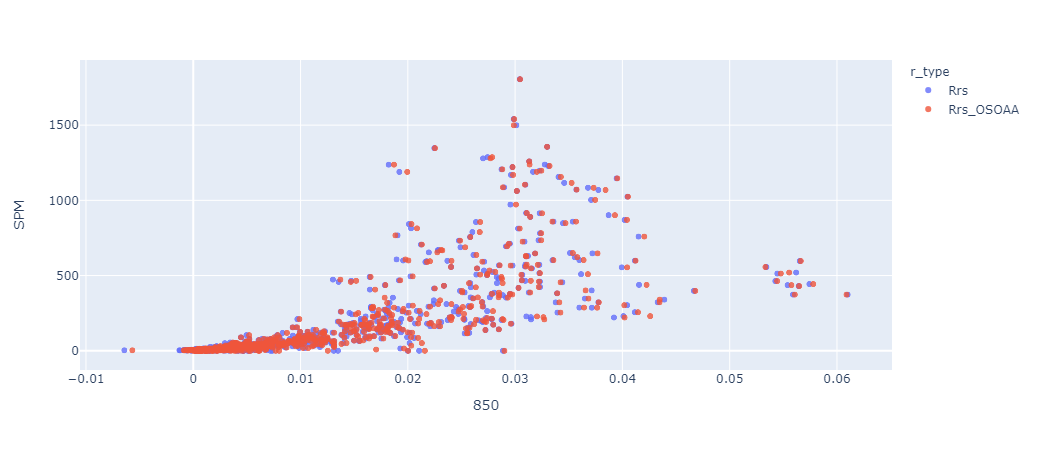

In [35]:
px.scatter(df, x='850', y='SPM', color='r_type', hover_data=['Area'], opacity=0.8)

### Low and High

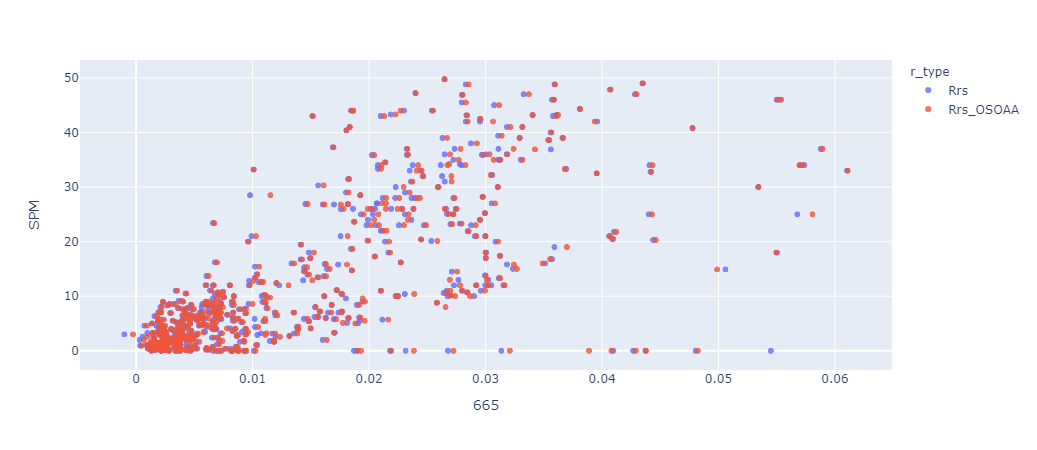

In [34]:
df_low = df[df['SPM'] < 50]
px.scatter(df_low, x='665', y='SPM', color='r_type', hover_data=['Area'], opacity=0.8)

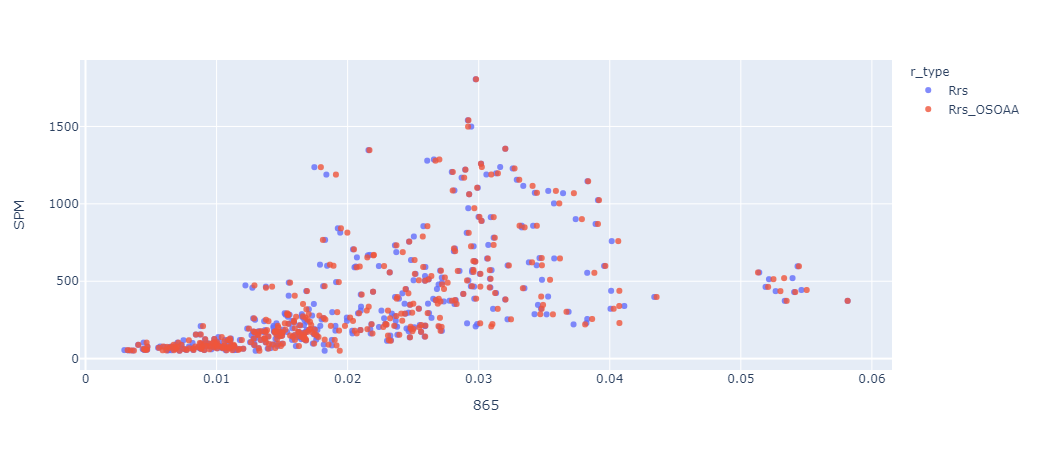

In [33]:
df_high = df[df['SPM'] > 50]
px.scatter(df_high, x='865', y='SPM', color='r_type', hover_data=['Area'], opacity=0.8, log_y=False)

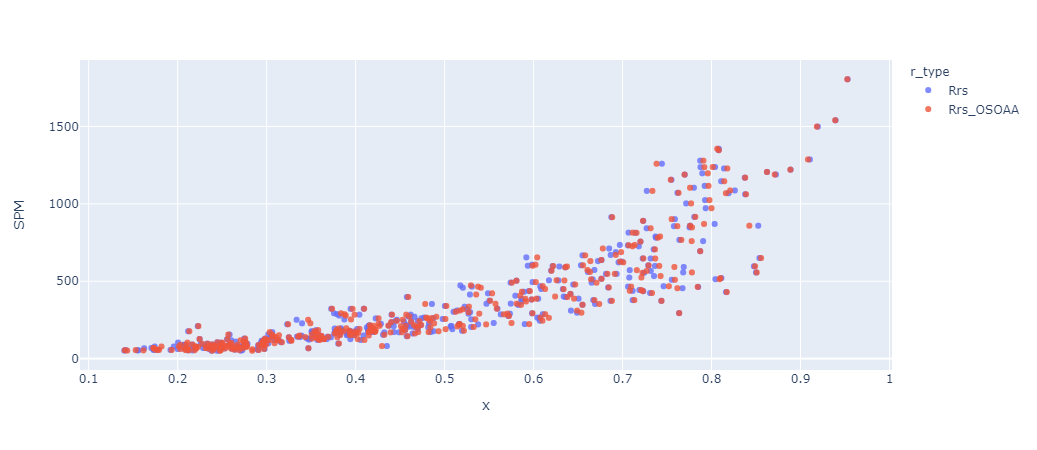

In [31]:
px.scatter(df_high, x=df_high['865']/df_high['665'], y='SPM', color='r_type', hover_data=['Area'], opacity=0.8, log_y=False)

## Comparing the Quality of the Fit for corrected and uncorrected reflectances

In [88]:
rrs = db.rdmtries['Rrs']
rrs_osoaa = db.rdmtries['Rrs_OSOAA']

for df in [rrs, rrs_osoaa]:
    # drop the missing SPM values
    df.dropna(subset=['SPM'], inplace=True)
    
    # drop the SPM=0 values
    df.query('SPM > 0', inplace=True)
    
    df.loc[(df['SPM'] > 0) & (df['SPM'] < 50) & (~pd.isna(rrs['SPM'])), 'SPM_Group'] = 'low'
    df.loc[df['SPM'] >= 50, 'SPM_Group'] = 'high'


### Results for uncorrected Reflectance

In [89]:
from WaterClass2.fitting import *
# 920 and 954 were added intentionally
s3bands = [400, 412, 442, 490, 510, 560, 620, 665, 674, 681, 709, 754, 779, 865, 885, 920, 945]

# we need them as strings, so...
s3bands = list(map(str, s3bands))

bands = s3bands + ['b865/b665']

In [102]:
gfit = GroupFit(rrs, bands, Fit.available_funcs, 'SPM_Group', metric='rmsle', criteria='min', thresh=10)

Fitting group=low
Fitting group=high


In [103]:
gfit.get_grouped_results() [['func', 'band', 'qty', 'rmsle', 'rmse', 'r2', 'SSE']]

,func,band,qty,rmsle,rmse,r2,SSE
low,expo,709,533,0.532931,7.6760,0.6728,3.140447e+04
high,power,b865/b665,376,0.289083,137.3754,0.8244,7.095875e+06
Overall,NaN,NaN,909,0.448445,88.5481,0.8922,7.127263e+06


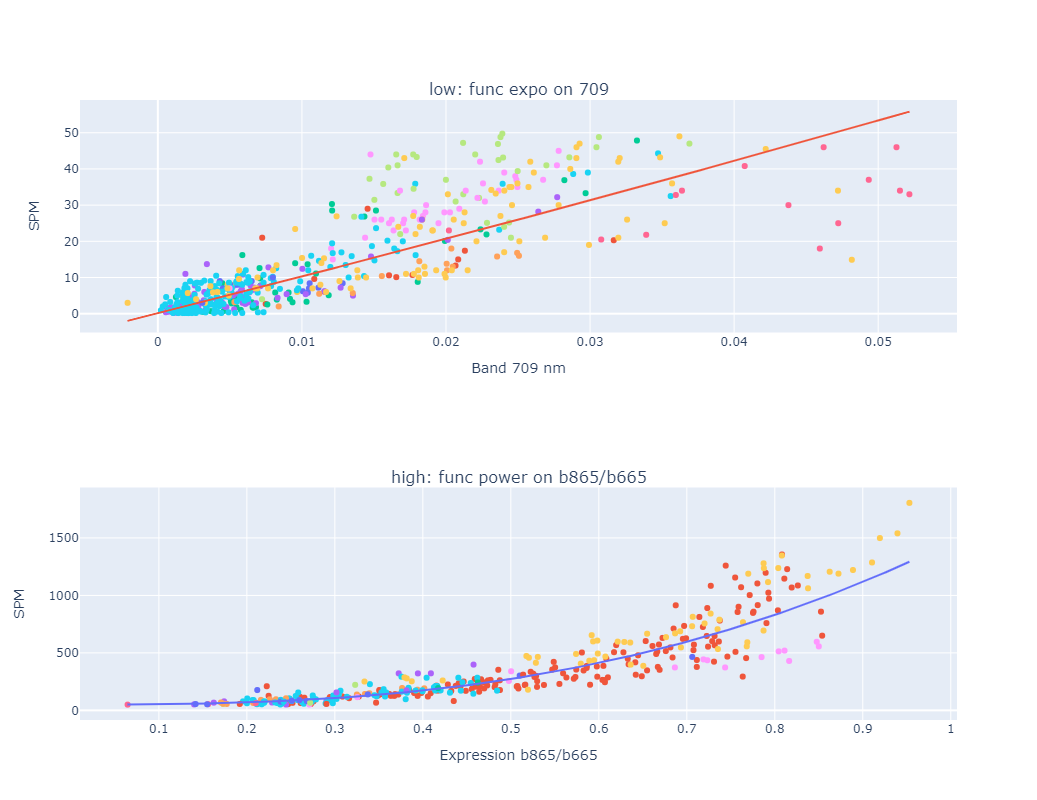

In [104]:
gfit.plot_groups(2, 1, base_height=400, color='Area', showlegend=False, )

### Results for uncorrected Reflectance

In [105]:
gfit = GroupFit(rrs_osoaa, bands, Fit.available_funcs, 'SPM_Group', metric='rmsle', criteria='min', thresh=10)

Fitting group=low
Fitting group=high


In [106]:
gfit.get_grouped_results() [['func', 'band', 'qty', 'rmsle', 'rmse', 'r2', 'SSE']]

,func,band,qty,rmsle,rmse,r2,SSE
low,expo,709,533,0.533941,7.7113,0.6698,3.169445e+04
high,power,b865/b665,376,0.288068,137.3968,0.8244,7.098088e+06
Overall,NaN,NaN,909,0.448879,88.5637,0.8922,7.129772e+06


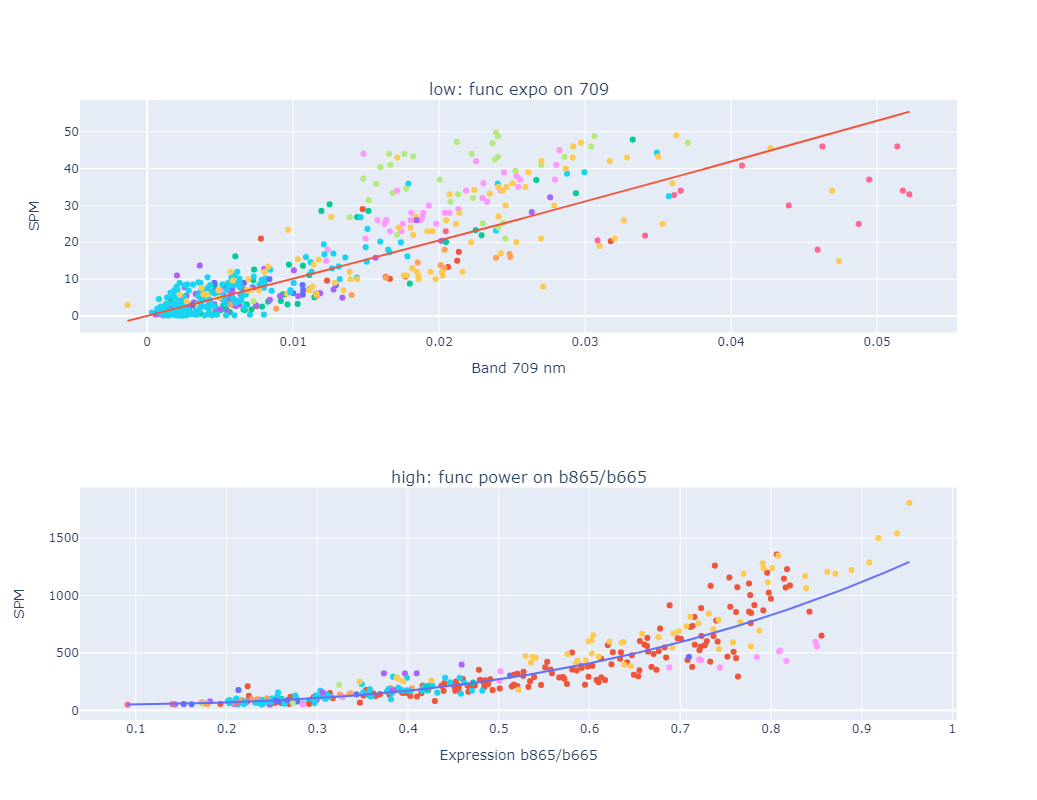

In [107]:
gfit.plot_groups(2, 1, base_height=400, color='Area', showlegend=False, )